# 02_train_purchase_model.ipynb

## Notebook Purpose
- Train purchase classifiers on **time-based splits** (no random split) to avoid temporal leakage.
- Compare models (LogReg, CatBoost, LightGBM) using **VALID PR-AUC** as the primary KPI (rare-event friendly).
- Select decision thresholds on **VALID only**:
  - F1-max threshold (trade-off operating point)
  - Precision ≥ 10% threshold (campaign-ready constraint)
  - Apply selected thresholds to TEST without re-tuning.
- Export artifacts for reproducibility:
  - Classification metrics → `artifacts/metrics/`
  - Raw predictions (required for downstream calibration) →
    - `artifacts/predictions/predictions_valid_raw.csv`
    - `artifacts/predictions/predictions_test_raw.csv`
  - PR curve figure → `artifacts/figures/pr_curve_valid.png`

## Experiment Design (at a glance)
- Problem setup: predict `y_purchase` (next 7 days) from user snapshot features built on a fixed history window.
- Split rule: boundaries are defined by **label_end** to prevent leakage across TRAIN/VALID/TEST.
- Model selection: choose the best model by **VALID PR-AUC** (ranking quality under extreme class imbalance).
- Decision policy: thresholds are tuned on **VALID only** to mimic real deployment (future remains unseen until TEST).

## Training approaches compared (3 methods)
- **Logistic Regression (logreg)**
  - Linear baseline on engineered features.
  - Fast and interpretable, but limited for complex non-linear interactions in behavioral data.

- **CatBoost Classifier**
  - Gradient-boosted decision trees; strong on heterogeneous tabular features (counts/recency/ratios) and non-linear patterns.
  - Typically robust when signals are weak and sparse.

- **LightGBM Classifier**
  - Gradient-boosted decision trees optimized for speed and scale.
  - Needs careful probability handling to ensure outputs are comparable (objective, correct probability API usage, calibration readiness).

## Context
- Shared inputs/outputs, file paths, and execution conventions are documented in the project README.

## Key Outcome

- **Best model:** `catboost` (highest **VALID PR-AUC**, i.e., best buyer-ranking under extreme class imbalance).
- **Why F1 looks low:** the base rate is ~0.2%, so even good models face a hard precision–recall trade-off; interpret results via PR-AUC and top-segment lift rather than absolute F1.
- **Why not LightGBM:** despite unusually low logloss/Brier, LightGBM shows **very weak PR-AUC** and **near-zero TP** at operational thresholds, indicating its outputs are not reliable for targeting in this setup (likely probability/evaluation mismatch).
- **Operational takeaway:** use CatBoost outputs for downstream calibration and campaign ranking; thresholds are selected on VALID only and then applied to TEST.
> Note: A deeper interpretation of metrics (F1 vs PR-AUC), the model selection rationale (CatBoost vs LightGBM), and a short glossary are provided at the end of this notebook.


In [13]:
# ============ Common PATH block (local only) ============
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\seony\Desktop\personal_project\purchase_prediction")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
MODELS_DIR = ARTIFACTS_DIR / "models"
PRED_DIR = ARTIFACTS_DIR / "predictions"
REPORTS_DIR = ARTIFACTS_DIR / "reports"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
FIGURES_DIR = ARTIFACTS_DIR / "figures"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: C:\Users\seony\Desktop\personal_project\purchase_prediction


In [14]:
# ============ Imports ============
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib

from catboost import CatBoostClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt

In [15]:
# ============ Inputs / outputs (fixed filenames) ============
USER_DATASET_PATH = PROCESSED_DIR / "user_dataset_hist23_label7_snapshots_v1.parquet"

METRICS_VALID_OUT = METRICS_DIR / "purchase_metrics_valid.csv"
METRICS_TEST_OUT  = METRICS_DIR / "purchase_metrics_test.csv"
THRESH_SEL_OUT    = METRICS_DIR / "threshold_selection.csv"

PRED_VALID_RAW = PRED_DIR / "predictions_valid_raw.csv"
PRED_TEST_RAW  = PRED_DIR / "predictions_test_raw.csv"

PR_CURVE_FIG_OUT = FIGURES_DIR / "pr_curve_best_model.png"

print("USER_DATASET_PATH:", USER_DATASET_PATH)

USER_DATASET_PATH: C:\Users\seony\Desktop\personal_project\purchase_prediction\data\processed\user_dataset_hist23_label7_snapshots_v1.parquet


In [16]:
# ============ Load dataset (time-based split already assigned) ============
df = pd.read_parquet(USER_DATASET_PATH)

# Force strictly binary label
df["y_purchase"] = (pd.to_numeric(df["y_purchase"], errors="coerce").fillna(0) > 0).astype("int8")
df["y_revenue"] = pd.to_numeric(df["y_revenue"], errors="coerce").fillna(0.0).astype("float32")

train = df[df["split"] == "train"].copy()
valid = df[df["split"] == "valid"].copy()
test  = df[df["split"] == "test"].copy()

drop_cols = ["user_id", "y_purchase", "y_revenue", "cutoff", "split"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X_train, y_train = train[feature_cols], train["y_purchase"].to_numpy()
X_valid, y_valid = valid[feature_cols], valid["y_purchase"].to_numpy()
X_test,  y_test  = test[feature_cols],  test["y_purchase"].to_numpy()

print("Shapes:", X_train.shape, X_valid.shape, X_test.shape)
print("Base rates:", float(y_train.mean()), float(y_valid.mean()), float(y_test.mean()))

Shapes: (651349, 14) (278847, 14) (253026, 14)
Base rates: 0.0014416234614622883 0.0020656489042378077 0.0019760815094101002


In [17]:
# ============ Metrics helpers ============

def compute_threshold_free_metrics(y_true: np.ndarray, p: np.ndarray) -> dict:
    p = np.clip(p, 1e-15, 1 - 1e-15)
    return {
        "base_rate": float(np.mean(y_true)),
        "roc_auc": float(roc_auc_score(y_true, p)),
        "pr_auc": float(average_precision_score(y_true, p)),
        "logloss": float(log_loss(y_true, p)),
        "brier": float(brier_score_loss(y_true, p)),
    }
    
def compute_threshold_metrics(y_true: np.ndarray, p: np.ndarray, thr: float) -> dict:
    y_pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0.0
    ppr = (tp + fp) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0.0
    return {
        "threshold": float(thr),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "accuracy": float(acc),
        "tp": int(tp),
        "fp": int(fp),
        "tn": int(tn),
        "fn": int(fn),
        "predicted_positive_rate": float(ppr),
    }

def select_thresholds(y_true: np.ndarray, p: np.ndarray, precision_floor: float = 0.10) -> dict:
    # Use PR curve thresholds (no brute force scan)
    prec, rec, thr = precision_recall_curve(y_true, p)
    prec_t = prec[1:]
    rec_t = rec[1:]

    f1 = (2 * prec_t * rec_t) / (prec_t + rec_t + 1e-15)
    i_f1 = int(np.argmax(f1)) if len(f1) else 0
    thr_f1 = float(thr[i_f1]) if len(thr) else 0.5

    ok = np.where(prec_t >= precision_floor)[0]
    if len(ok) == 0:
        thr_p10 = 1.0
    else:
        i = ok[int(np.argmax(rec_t[ok]))]
        thr_p10 = float(thr[i])

    return {
        "threshold_f1_max": thr_f1,
        "threshold_precision_10pct": thr_p10,
        "precision_floor": float(precision_floor),
    }

In [18]:
# ============ Model definitions ============
lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000,
        random_state=42,
    )),
])

cb = CatBoostClassifier(
    loss_function="Logloss",
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=5.0,
    random_seed=42,
    auto_class_weights="Balanced",
    eval_metric="Logloss",
    early_stopping_rounds=200,
    verbose=200,
)

lgbm = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced",
)

models = {"logreg": lr, "catboost": cb, "lightgbm": lgbm}
print("Models:", list(models.keys()))

Models: ['logreg', 'catboost', 'lightgbm']


In [19]:
# ============ Train + evaluate ============
results_valid, results_test, thr_rows = [], [], []
pred_cache = {}

for name, model in models.items():
    print("\n" + "="*80)
    print("Training:", name)

    if name == "catboost":
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
        p_valid = model.predict_proba(X_valid)[:, 1]
        p_test  = model.predict_proba(X_test)[:, 1]

    elif name == "lightgbm":
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="binary_logloss",
            callbacks=[lgb.early_stopping(200, verbose=False)],
        )
        p_valid = model.predict_proba(X_valid)[:, 1]
        p_test  = model.predict_proba(X_test)[:, 1]

    else:
        model.fit(X_train, y_train)
        p_valid = model.predict_proba(X_valid)[:, 1]
        p_test  = model.predict_proba(X_test)[:, 1]

    pred_cache[name] = {"p_valid": p_valid, "p_test": p_test}

    thrs = select_thresholds(y_valid, p_valid, precision_floor=0.10)
    thr_f1 = thrs["threshold_f1_max"]
    thr_p10 = thrs["threshold_precision_10pct"]

    tf_valid = compute_threshold_free_metrics(y_valid, p_valid)
    tf_test  = compute_threshold_free_metrics(y_test,  p_test)

    m_f1_valid = compute_threshold_metrics(y_valid, p_valid, thr_f1)
    m_p10_valid = compute_threshold_metrics(y_valid, p_valid, thr_p10)

    m_f1_test = compute_threshold_metrics(y_test, p_test, thr_f1)
    m_p10_test = compute_threshold_metrics(y_test, p_test, thr_p10)

    def row(tf, m1, m2):
        return {
            **tf,
            "threshold_f1_max": float(m1["threshold"]),
            "threshold_f1_max_precision": m1["precision"],
            "threshold_f1_max_recall": m1["recall"],
            "threshold_f1_max_f1": m1["f1"],
            "threshold_f1_max_accuracy": m1["accuracy"],
            "threshold_f1_max_tp": m1["tp"],
            "threshold_f1_max_fp": m1["fp"],
            "threshold_f1_max_tn": m1["tn"],
            "threshold_f1_max_fn": m1["fn"],
            "threshold_f1_max_predicted_positive_rate": m1["predicted_positive_rate"],
            "threshold_precision_10pct": float(m2["threshold"]),
            "threshold_precision_10pct_precision": m2["precision"],
            "threshold_precision_10pct_recall": m2["recall"],
            "threshold_precision_10pct_f1": m2["f1"],
            "threshold_precision_10pct_accuracy": m2["accuracy"],
            "threshold_precision_10pct_tp": m2["tp"],
            "threshold_precision_10pct_fp": m2["fp"],
            "threshold_precision_10pct_tn": m2["tn"],
            "threshold_precision_10pct_fn": m2["fn"],
            "threshold_precision_10pct_predicted_positive_rate": m2["predicted_positive_rate"],
        }

    results_valid.append({"model": name, **row(tf_valid, m_f1_valid, m_p10_valid)})
    results_test.append({"model": name, **row(tf_test,  m_f1_test,  m_p10_test)})
    thr_rows.append({"model": name, **thrs})

valid_df = pd.DataFrame(results_valid).sort_values("pr_auc", ascending=False).reset_index(drop=True)
test_df  = pd.DataFrame(results_test).set_index("model").loc[valid_df["model"]].reset_index()

valid_df.to_csv(METRICS_VALID_OUT, index=False)
test_df.to_csv(METRICS_TEST_OUT, index=False)
pd.DataFrame(thr_rows).to_csv(THRESH_SEL_OUT, index=False)

print("\nSaved:")
print(" -", METRICS_VALID_OUT)
print(" -", METRICS_TEST_OUT)
print(" -", THRESH_SEL_OUT)

display(valid_df)


Training: logreg

Training: catboost
0:	learn: 0.6613825	test: 0.6616137	best: 0.6616137 (0)	total: 181ms	remaining: 6m 1s
200:	learn: 0.3404020	test: 0.4860346	best: 0.4353199 (43)	total: 9.15s	remaining: 1m 21s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4353199365
bestIteration = 43

Shrink model to first 44 iterations.

Training: lightgbm
[LightGBM] [Info] Number of positive: 939, number of negative: 650410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1627
[LightGBM] [Info] Number of data points in the train set: 651349, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Saved:
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\

,model,base_rate,roc_auc,pr_auc,logloss,brier,threshold_f1_max,threshold_f1_max_precision,threshold_f1_max_recall,threshold_f1_max_f1,...,threshold_precision_10pct,threshold_precision_10pct_precision,threshold_precision_10pct_recall,threshold_precision_10pct_f1,threshold_precision_10pct_accuracy,threshold_precision_10pct_tp,threshold_precision_10pct_fp,threshold_precision_10pct_tn,threshold_precision_10pct_fn,threshold_precision_10pct_predicted_positive_rate
0,catboost,0.002066,0.877990,0.046840,0.413211,0.123886,0.955583,0.104874,0.123264,0.113328,...,0.954489,0.099863,0.126736,0.111706,0.995836,73,658,277613,503,0.002622
1,logreg,0.002066,0.878587,0.028518,0.463733,0.134674,0.981281,0.053401,0.164931,0.080679,...,1.000000,0.000000,0.000000,0.000000,0.997902,0,9,278262,576,0.000032
2,lightgbm,0.002066,0.717449,0.007353,0.024833,0.004255,0.208718,0.021680,0.055556,0.031189,...,0.999658,0.000000,0.000000,0.000000,0.997931,0,1,278270,576,0.000004


In [22]:
# ============ Save models + predictions (best model by VALID PR-AUC) ============
best_model = str(valid_df.loc[0, "model"])
print("Best model:", best_model)

# Save model artifact
if best_model == "catboost":
    models["catboost"].save_model(MODELS_DIR / "purchase_model_catboost.cbm")
else:
    joblib.dump(models["logreg"], MODELS_DIR / "purchase_model_logreg.joblib")

# Build predictions files (MUST be saved before calibration)
p_valid = pred_cache[best_model]["p_valid"]
p_test  = pred_cache[best_model]["p_test"]

pred_valid = valid[["user_id", "cutoff", "y_purchase", "y_revenue"]].copy()
pred_test  = test[["user_id", "cutoff", "y_purchase", "y_revenue"]].copy()

pred_valid["p_hat"] = p_valid
pred_test["p_hat"]  = p_test
pred_valid["p_hat_model"] = best_model
pred_test["p_hat_model"]  = best_model

pred_valid.to_csv(PRED_VALID_RAW, index=False)
pred_test.to_csv(PRED_TEST_RAW, index=False)

print("Saved:")
print(" -", PRED_VALID_RAW)
print(" -", PRED_TEST_RAW)

display(pred_valid.head(5))

Best model: catboost
Saved:
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions\predictions_valid_raw.csv
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions\predictions_test_raw.csv


,user_id,cutoff,y_purchase,y_revenue,p_hat,p_hat_model
651349,1515915625353230683,2020-12-27 00:00:00+00:00,0,0.0,0.128091,catboost
651350,1515915625353234047,2020-12-27 00:00:00+00:00,0,0.0,0.110201,catboost
651351,1515915625353294441,2020-12-27 00:00:00+00:00,0,0.0,0.531393,catboost
651352,1515915625353400724,2020-12-27 00:00:00+00:00,0,0.0,0.573701,catboost
651353,1515915625353416040,2020-12-27 00:00:00+00:00,0,0.0,0.734995,catboost


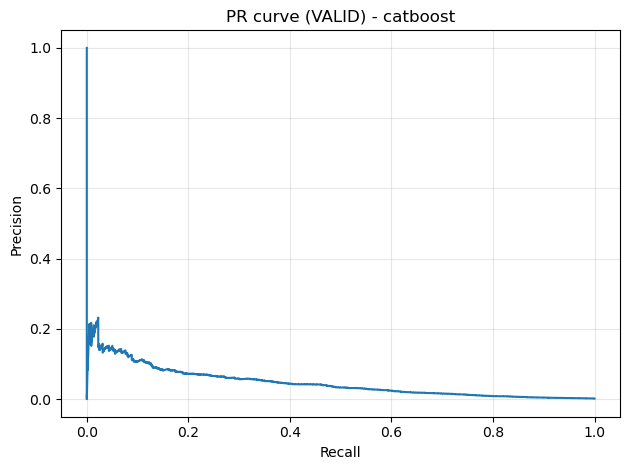

Saved: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\figures\pr_curve_best_model.png


In [23]:
# ============ PR curve (best model) ============
prec, rec, _ = precision_recall_curve(y_valid, pred_cache[best_model]["p_valid"])

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR curve (VALID) - {best_model}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PR_CURVE_FIG_OUT, dpi=150)
plt.show()

print("Saved:", PR_CURVE_FIG_OUT)

## 1) Why F1 is structurally low in this task

- **Base rate is extremely low** (≈ 0.2%): most snapshots are negatives.
- With such imbalance:
  - Increasing **recall** usually creates many **false positives** (precision drops).
  - Increasing **precision** often collapses **recall** (few or zero true positives).
- Therefore, **absolute F1 values look small by design**; what matters is whether the model can create a **high-lift top segment** (campaign targeting).

---

## 2) Why the primary KPI is PR-AUC (not ROC-AUC / accuracy)

- In rare-event problems, **accuracy and ROC-AUC can look deceptively good** while the model fails to surface positives in the top ranks.
- **PR-AUC focuses on the positive class** and directly measures whether the model can rank likely buyers above non-buyers.
- This matches the business use case: **prioritize the top-k audience** under limited campaign budget.

---

## 3) Why CatBoost is judged best (and why LightGBM is not)

- **CatBoost wins on the correct KPI**
  - **PR-AUC (VALID)** is highest for CatBoost, indicating the best buyer-ranking quality.
  - Threshold-based checks show CatBoost is the only model yielding **non-trivial TP counts** under realistic constraints (e.g., Precision ≥ 10%).
- **LightGBM appears “good” only on probability-loss metrics, but fails where it matters**
  - LightGBM shows **very low logloss/Brier** yet **very poor PR-AUC** and **near-zero TP** at decision thresholds.
  - This combination is a red flag: it commonly indicates that the “probabilities” being evaluated are **not comparable** (e.g., wrong prediction API used, probabilities collapsed near 0/1, or evaluation mismatch).
  - In short: LightGBM’s numbers look attractive in isolation, but **the ranking and operational usefulness collapse**, so it is not a valid “best model” for campaign targeting.

---

## Notes: Quick definitions (for reference)

- **Base rate**: The fraction of positives in the dataset (`mean(y_true)`).
- **ROC-AUC**: Ranking quality across all thresholds; can look strong even in extreme imbalance.
- **PR-AUC (Average Precision)**: Ranking quality focused on the positive class; preferred for rare events.
- **Log loss (cross-entropy)**: Penalizes confident wrong probabilities strongly; evaluates probability quality.
- **Brier score**: Mean squared error between predicted probability and actual label; another probability-quality metric.
- **F1 score**: Harmonic mean of precision and recall; often low in rare-event problems.
- **TP/FP/TN/FN**: Counts of correct/incorrect positives/negatives under a chosen threshold.
- **Predicted positive rate**: Fraction predicted as positive at a threshold (campaign size proxy).